In [2]:
import mysql.connector as sql
import pandas as pd
import datetime as dt
import numpy as np
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *
import matplotlib.pyplot as plt
import math
import requests
import json
from pandas.io.json import json_normalize
import matplotlib.dates as mdates
from datetime import date, timedelta
from requests.packages.urllib3.util.retry import Retry
from wordcloud import WordCloud, STOPWORDS 

In [4]:
db_connection = sql.connect(host='localhost', database='collection_users', user='pandas', password='password')
sbItems = pd.read_sql('SELECT * FROM UsersShoeboxItems', con=db_connection)
sbItems['tool_id'] = sbItems['tool_id'].astype('category')
sbItems['extension'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['extension'] = sbItems['extension'].astype('category')
sbItems['mimetype'] = sbItems['mimetype'].astype('category')
sbItems['created'] = pd.to_datetime(sbItems['created'], unit='s').dt.tz_localize('utc').dt.tz_convert('US/Eastern')
sbItems['lastmodified'] = pd.to_datetime(sbItems['lastmodified'], unit='s').dt.tz_localize('utc').dt.tz_convert('US/Eastern')
sbItems['deleted'].replace(0, np.nan, inplace=True)
sbItems['deleted'] = pd.to_datetime(sbItems['deleted'], unit='s').dt.tz_localize('utc').dt.tz_convert('US/Eastern')
sbItems['refers_to_uid'] = sbItems['refers_to_uid'].astype(int)
sbItems['fingerprint'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['title'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['description'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['secret'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['secret_o'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['extras'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option("max_colwidth", 500)

In [5]:
url = 'https://api.collection.cooperhewitt.org/rest/?method=cooperhewitt.objects.getInfo&access_token=729cca8ffeb40cd2e725f5301e034134&object_id=69155331'
resp = requests.request('GET', url)
resp.status_code
items = json.loads(resp.text)
items = pd.json_normalize(items)
items

,stat,event_publishing_state,object.id,object.tms:id,object.accession_number,object.title,object.title_raw,object.url,object.has_no_known_copyright,object.department_id,object.period_id,object.media_id,object.type_id,object.date,object.year_start,object.year_end,object.year_acquired,object.decade,object.woe:country_id,object.medium,object.markings,object.signed,object.inscribed,object.provenance,object.dimensions,object.dimensions_raw,object.creditline,object.description,object.justification,object.gallery_text,object.label_text,object.videos,object.on_display,object.woe:country,object.type,object.images,object.participants,object.is_loan_object
0,ok,ok,69155331,282992,"7.2015.1a,b","Scale Models, Architecture is Everywhere, 2015",Architecture is Everywhere,https://collection.cooperhewitt.org/objects/69155331/,None,404529577,None,420568395,420560743,2015,2015,2015,None,2010,None,"wood, aluminum, ceramic, dried flowers, fabric, paper, plastic, sponge, stainless steel",None,None,None,None,H x W x D (each): 10 × 15 × 15 cm (3 15/16 × 5 7/8 × 5 7/8 in.) (approx.),None,Courtesy of Sou Fujimoto Architects,None,None,"Sou Fujimoto Architects created this series of models for the 2015 Chicago Architecture Biennial. Called Architecture Is Everywhere, the project discovers architectural possibility in found objects and everyday materials. Simple artifacts such as a lottery ticket, an ashtray, or a ring of binder clips become intriguing structures when placed on pedestals with tiny human figures. In the words of Sou Fujimoto, “This is kind of a funny trial to expand our ideas of architecture beyond our usual...",None,None,None,None,Scale models,"[{'b': {'url': 'https://images.collection.cooperhewitt.org/269364_5f9ebc42b614bc22_b.jpg', 'width': 1024, 'height': 644, 'is_primary': '1', 'image_id': '269364'}, 'z': {'url': 'https://images.collection.cooperhewitt.org/269364_5f9ebc42b614bc22_z.jpg', 'width': 640, 'height': 402, 'is_primary': '1', 'image_id': '269364'}, 'n': {'url': 'https://images.collection.cooperhewitt.org/269364_5f9ebc42b614bc22_n.jpg', 'width': 320, 'height': 201, 'is_primary': '1', 'image_id': '269364'}, 'd': {'url': ...","[{'person_id': '69154757', 'role_id': '35236655', 'person_name': 'Sou Fujimoto Architects', 'person_date': 'Tokyo, Japan, founded 2000', 'role_name': 'Designer', 'role_display_name': 'Designed by', 'person_url': 'https://collection.cooperhewitt.org/people/69154757/', 'role_url': 'https://collection.cooperhewitt.org/roles/35236655/'}, {'person_id': '69154757', 'role_id': '51571131', 'person_name': 'Sou Fujimoto Architects', 'person_date': 'Tokyo, Japan, founded 2000', 'role_name': 'Lender', '...",1


In [6]:
popular = sbItems['refers_to_uid'].value_counts().nlargest(100)

In [7]:
def fetch_URL(url):
    session = requests.Session()
    retry = Retry(connect = 3, backoff_factor = 0.5)
    adapter = requests.adapters.HTTPAdapter(max_retries = retry)
    session.mount('https://', adapter)
    
    return session.get(url)

In [8]:
popular_items = popular.index.astype(str)
items_info = None
errs = []
for item in popular_items:
    try:
        url = 'https://api.collection.cooperhewitt.org/rest/?method=cooperhewitt.objects.getInfo&access_token=729cca8ffeb40cd2e725f5301e034134&object_id=' + item
        resp = fetch_URL(url)
        items = json.loads(resp.text)
        items = pd.json_normalize(items)
        if items_info is None:
            items_info = items
        else:
            items_info = pd.concat([items_info, items])
    except RuntimeError as e:
        errs.append(e)
items_info

# 100 popular items

,stat,event_publishing_state,object.id,object.tms:id,object.accession_number,object.title,object.title_raw,object.url,object.has_no_known_copyright,object.department_id,object.period_id,object.media_id,object.type_id,object.date,object.year_start,object.year_end,object.year_acquired,object.decade,object.woe:country_id,object.medium,object.markings,object.signed,object.inscribed,object.provenance,object.dimensions,object.dimensions_raw.depth,object.dimensions_raw.height,object.dimensions_raw.width,object.creditline,object.description,object.justification,object.gallery_text,object.label_text,object.videos,object.on_display,object.woe:country,object.type,object.images,object.participants,object.woe:country_name,object.is_loan_object,object.dimensions_raw.diameter,object.dimensions_raw,error.code,error.error,error.message
0,ok,ok,18703475,227515,2007-45-11,"Staircase Model (France), late 18th century",,https://collection.cooperhewitt.org/objects/18703475/,None,35347497,None,2318799985,35302429,late 18th century,None,None,2007,None,23424819,"pear, brass wire, bone",None,None,None,Eugene V. and Clare E. Thaw; 2007: acquired by Museum,H x W x D: 75 x 67.3 x 67 cm (29 1/2 x 26 1/2 x 26 3/8 in.),"[67.00, centimeters]","[75.00, centimeters]","[67.30, centimeters]",Gift of Eugene V. and Clare E. Thaw,Double-revolution super-imposed staircase model.,None,None,This fine triple-height staircase model is similar to one designed by Robert Adam for 20 Portman Place in London. The model’s sustaining pillars ensure stability in place of the walls used in Adam’s staircase. The pillars are joined in a manner characteristic of a builder rather than a compagnonnage-trained cabinetmaker.,None,None,23424819,Staircase model,"[{'b': {'url': 'https://images.collection.cooperhewitt.org/90933_71d437d4fe573bab_b.jpg', 'width': 1024, 'height': 1024, 'is_primary': '1', 'image_id': '90933'}, 'z': {'url': 'https://images.collection.cooperhewitt.org/90933_71d437d4fe573bab_z.jpg', 'width': 640, 'height': 640, 'is_primary': '1', 'image_id': '90933'}, 'n': {'url': 'https://images.collection.cooperhewitt.org/90933_71d437d4fe573bab_n.jpg', 'width': 320, 'height': 320, 'is_primary': '1', 'image_id': '90933'}, 'sq': {'url': 'htt...","[{'person_id': '68736639', 'role_id': '2318792694', 'person_name': 'Eugene V. Thaw', 'person_date': '', 'role_name': 'Previous owner', 'role_display_name': 'Previously owned by', 'person_url': 'https://collection.cooperhewitt.org/people/68736639/', 'role_url': 'https://collection.cooperhewitt.org/roles/2318792694/'}, {'person_id': '68736639', 'role_id': '35351535', 'person_name': 'Eugene V. Thaw', 'person_date': '', 'role_name': 'Donor', 'role_display_name': 'Donated by', 'person_url': 'http...",France,0.0,NaN,NaN,NaN,NaN,NaN
0,ok,ok,18703477,227516,2007-45-12,"Staircase Model (France), early 19th century",,https://collection.cooperhewitt.org/objects/18703477/,None,35347497,None,2318799986,35302429,early 19th century,None,None,2007,None,23424819,"mahogany, ebony, pear or sycamore, oak; biscuit porcelain",None,None,None,Eugene V. and Clare E. Thaw; 2007: acquired by Museum,H x W x D: 68 x 48.3 x 41 cm (26 3/4 in. x 19 in. x 16 1/8 in.),"[41.00, centimeters]","[68.00, centimeters]","[48.30, centimeters]",Gift of Eugene V. and Clare E. Thaw,"Model of a curved double staircase reaching a landing and continuing up as a single stair; steps and risers inlaid in contrasting wood to emulate carpet; busts of Francois-Marie Arouet, called Voltaire (1694-1778), and Jean-Jacques Rousseau (1712-1778) made of Sèvres biscuit porcelain on newel posts at top.",None,None,"This double revolution staircase is unmistakably a masterwork, confirmed by details such as the carefully turned, ebony balusters and the sophisticated veneering used to create an inlaid “carpet.” A hint of revolutionary politics is introduced through a juxtaposition of Sèvres biscuit porcelain busts of the French philosophers Voltaire (left) and Jean-Jacques Rousseau (right).",None,None,2

In [9]:
def fetch_exhibition(object_id):
    url_exhibition = 'https://api.collection.cooperhewitt.org/rest/?method=cooperhewitt.objects.getExhibitions&access_token=729cca8ffeb40cd2e725f5301e034134&id=' + str(object_id)
    resp = fetch_URL(url_exhibition)
    exhibition_object = json.loads(resp.text)
    if exhibition_object.get('count_exhibitions', 0) == 0:
        return None
    exhibition_object_id = exhibition_object['object_id']
    exhibition_id = exhibition_object['exhibitions'][0]['id']
    exhibition_title = exhibition_object['exhibitions'][0]['title']
    exhibition_date_start = exhibition_object['exhibitions'][0]['date_start']
    exhibition_date_end = exhibition_object['exhibitions'][0]['date_end']
    exhibition_results = [{'exhibition_object_id': exhibition_object_id,'exhibition_id': exhibition_id, 'exhibition_title': exhibition_title, 
                           'exhibition_date_start': exhibition_date_start, 'exhibition_date_end': exhibition_date_end}]
    return pd.DataFrame(exhibition_results)

In [10]:
popular_items = popular.index.astype(str)

object_exhibition = None
errs = []

for item in popular_items:
    try:
        exhibition_data = fetch_exhibition(item)
        if exhibition_data is None:
            continue
        if object_exhibition is None:
            object_exhibition = exhibition_data
        else:
            object_exhibition = pd.concat([object_exhibition, exhibition_data])
    except RuntimeError as e:
        errs.append(e)
object_exhibition

,exhibition_object_id,exhibition_id,exhibition_title,exhibition_date_start,exhibition_date_end
0,18703475,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03
0,18703477,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03
0,18703473,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03
0,18703503,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03
0,18703485,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03
0,18703481,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03
0,69192475,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21
0,18733333,69117611,The Jazz Age: American Style in the 1920s,2017-04-07,2017-08-20
0,18187831,51668989,Hewitt Sisters Collect,2014-12-12,2017-10-29
0,18703479,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03


# to join by date

In [8]:
object_exhibition.rename({'exhibition_object_id': 'object_id'}, axis=1, inplace=True)

In [9]:
items_info.rename({'object.id': 'object_id'}, axis=1, inplace=True)

In [10]:
merged_date = object_exhibition.merge(items_info, on='object_id', suffixes=('_item_info', '_exhibition'))
merged_date

,object_id,exhibition_id,exhibition_title,exhibition_date_start,exhibition_date_end,stat,event_publishing_state,object.tms:id,object.accession_number,object.title,...,object.woe:country_name,object.is_loan_object,object.dimensions_raw.diameter,object.dimensions_raw,error.code,error.error,error.message,object.dimensions_raw.length,object.dimensions_raw.warp,object.dimensions_raw.weft
0,18703475,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,ok,ok,227515,2007-45-11,"Staircase Model (France), late 18th century",...,France,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18703477,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,ok,ok,227516,2007-45-12,"Staircase Model (France), early 19th century",...,France,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18703473,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,ok,ok,227514,2007-45-10,"Staircase Model (France), mid–late 19th century",...,France,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18703503,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,ok,ok,227529,2014-11-3,"Dome-shaped Architectural Staircase Model, mid...",...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18703485,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,ok,ok,227520,2014-11-2,"Curved Staircase Model In The French Style, ca...",...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,69192511,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21,ok,ok,283400,38.2015.1a/c,"Ensemble With Jacket, from Spring/Summer 2014 ...",...,NaN,1.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
260,18447273,51668983,Making Design,2014-12-12,2016-09-01,ok,ok,134152,1963-39-139,"Poster, American Airlines to New York, 1948",...,United States,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,69192515,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21,ok,ok,283401,"38.2015.2a,b","Graffiti V-neck Tee And Pants, from Spring / S...",...,NaN,1.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
262,69155051,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21,ok,ok,282876,"2016-24-1-a,b",from the Spotted Nyonya series Vessel With Cov...,...,NaN,0.0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
merged_date.head(20)

,object_id,exhibition_id,exhibition_title,exhibition_date_start,exhibition_date_end,object.title,object.url,object.department_id,object.type_id,object.date,object.medium,object.provenance,object.dimensions,object.description,object.label_text,object.type,object.images
0,18703475,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,"Staircase Model (France), late 18th century",https://collection.cooperhewitt.org/objects/18...,35347497,35302429,late 18th century,"pear, brass wire, bone",Eugene V. and Clare E. Thaw; 2007: acquired by...,H x W x D: 75 x 67.3 x 67 cm (29 1/2 x 26 1/2 ...,Double-revolution super-imposed staircase model.,This fine triple-height staircase model is sim...,Staircase model,[{'b': {'url': 'https://images.collection.coop...
1,18703477,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,"Staircase Model (France), early 19th century",https://collection.cooperhewitt.org/objects/18...,35347497,35302429,early 19th century,"mahogany, ebony, pear or sycamore, oak; biscui...",Eugene V. and Clare E. Thaw; 2007: acquired by...,H x W x D: 68 x 48.3 x 41 cm (26 3/4 in. x 19 ...,Model of a curved double staircase reaching a ...,This double revolution staircase is unmistakab...,Staircase model,[{'b': {'url': 'https://images.collection.coop...
2,18703473,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,"Staircase Model (France), mid–late 19th century",https://collection.cooperhewitt.org/objects/18...,35347497,35302429,mid–late 19th century,oak,Eugene V. and Clare E. Thaw; 2007: acquired by...,H x W x D: 52 x 71 x 44 cm (20 1/2 x 27 15/16 ...,Double-revolution staircase model with curved ...,This double-revolution staircase model is simi...,Staircase model,[{'b': {'url': 'https://images.collection.coop...
3,18703503,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,"Dome-shaped Architectural Staircase Model, mid...",https://collection.cooperhewitt.org/objects/18...,35347497,68765497,mid-19th century,walnut and beechwood,None,H: 61 x W: 67.3 x D: 47 cm (24 x 26 1/2 x 18 1...,The double staircase spiralling into a single ...,This maîtrise (masterpiece) in the 17th-centur...,Architectural Staircase Model,[{'b': {'url': 'https://images.collection.coop...
4,18703485,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,"Curved Staircase Model In The French Style, ca...",https://collection.cooperhewitt.org/objects/18...,35347497,68778363,ca. 1850,"carved, planed, turned, and veneered walnut",None,H x W x D: 30 x 28 x 43.5 cm (11 13/16 in. x 1...,None,None,Curved Staircase Model in the French Style,[{'b': {'url': 'https://images.collection.coop...
5,18703481,35350895,Made to Scale: Staircase Masterpieces—The Euge...,2006-10-13,2007-06-03,"Bell Tower Model, ca. 1880",https://collection.cooperhewitt.org/objects/18...,35347497,35302431,ca. 1880,carved and turned pearwood,None,H: 121 x W: 41.9 x D: 41.9 cm (47 5/8 x 16 1/2...,Bell tower model with spiral staircase,This masterwork is a virtuosity of joinery. It...,Bell Tower Model,[{'b': {'url': 'https://images.collection.coop...
6,69192475,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21,"PolyThread Knitted Textile Pavilion, PolyThrea...",https://collection.cooperhewitt.org/objects/69...,404529577,420561595,2015–2016,3d seamless whole garment digitally knit cone ...,None,Site specific installation,None,None,PolyThread knitted textile pavilion,[{'b': {'url': 'https://images.collection.coop...
7,18733333,69117611,The Jazz Age: American Style in the 1920s,2017-04-07,2017-08-20,Chanin Building Pair Of Gates,https://collection.cooperhewitt.org/objects/18...,35347497,51588791,None,"wrought iron, bronze",None,None,None,"These gates, from the entrance to the Chanin B...",Pair of Gates,[{'b': {'url': 'https://images.collection.coop...
8,18187831,51668989,Hewitt Sisters Collect,2014-12-12,2017-10-29,Birdcage (China),https://coll

In [11]:
merged_date.drop(['stat', 'event_publishing_state', 'object.tms:id', 'object.accession_number', 'object.title_raw',
                 'object.has_no_known_copyright', 'object.period_id', 'object.media_id', 'object.year_start',
                 'object.year_end', 'object.year_acquired', 'object.decade', 'object.woe:country_id', 'object.markings',
                 'object.signed', 'object.inscribed', 'object.creditline', 'object.justification', 'object.gallery_text',
                 'object.videos', 'object.on_display', 'object.woe:country', 'object.participants', 'object.woe:country_name',
                 'object.is_loan_object', 'object.dimensions_raw.diameter', 'object.dimensions_raw', 'error.code',
                 'error.error', 'error.message', 'object.dimensions_raw.length', 'object.dimensions_raw.warp', 'object.dimensions_raw.weft',
                 'object.dimensions_raw.depth', 'object.dimensions_raw.height', 'object.dimensions_raw.width'], axis=1, inplace=True)

Text(0.5, 1.0, 'exhibitions of the most collected items')

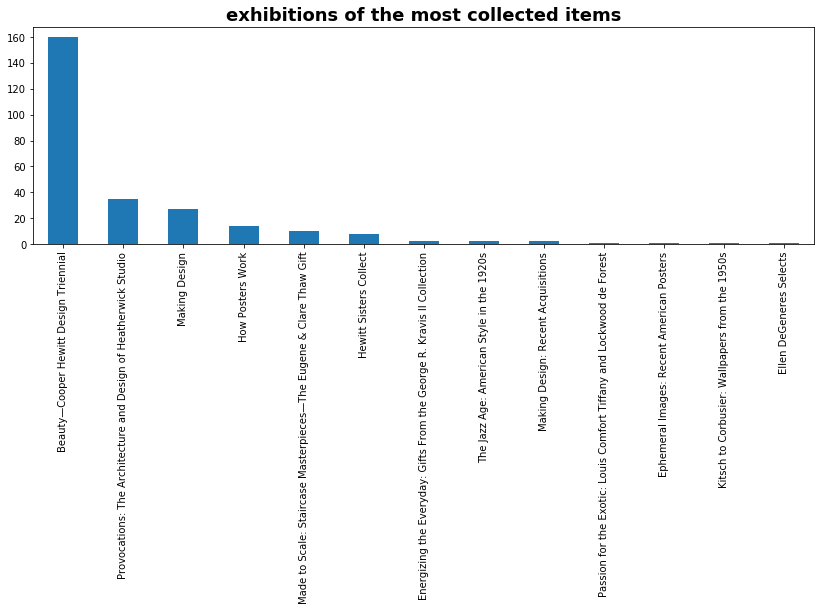

In [12]:
fig, ax = plt.subplots(figsize = (14,4))

top_exhibition = merged_date['exhibition_title'].value_counts()
top_exhibition.plot.bar(top_exhibition.index, y='exhibition_title', rot=0)
plt.xticks(rotation=90)
ax.set_title("Exhibition Title", size = 14)
plt.xticks(x=merged_date['exhibition_title'])
plt.title('exhibitions of the most collected items', fontdict={'fontweight': 'bold', 'fontsize':18})
# plt.savefig('exhibition_collected_items.png', dpi=300)

In [13]:
merged_date['exhibition_title'].value_counts()
top_exhibition.to_frame()

,exhibition_title
Beauty—Cooper Hewitt Design Triennial,160
Provocations: The Architecture and Design of Heatherwick Studio,35
Making Design,27
How Posters Work,14
Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,10
Hewitt Sisters Collect,8
Energizing the Everyday: Gifts From the George R. Kravis II Collection,2
The Jazz Age: American Style in the 1920s,2
Making Design: Recent Acquisitions,2
Passion for the Exotic: Louis Comfort Tiffany and Lockwood de Forest,1


In [17]:
merged_no_staircase_items = merged_date[~merged_date['exhibition_title'].str.contains('Staircase')]
#without the staircases

In [19]:
merged_no_staircase_items['object_id'].head(10)
#it's already sorted by nlargest

6      69192475
7      18733333
8      18187831
10     69155331
12     69172097
13     69172091
14     69172093
15     69172085
16    404529347
17     69172095
Name: object_id, dtype: object